<br /><br /><br />
# Recognizing handwritten digits using a neural network

We have now reached the point where we can tackle a very interesting task: applying the knowledge we have gained with machine learning in general, and `Flux.jl` in particular, to create a neural network that can recognize handwritten digits! The data are from a data set called MNIST, which has become a classic in the machine learning world.

[We could also try to apply the techniques to the original images of fruit instead. However, the fruit images are much larger than the MNIST images, which makes the learning a suitable neural network too slow.]

## Data munging

As we know, the first difficulty with any new data set is locating it, understanding what format it is stored in, reading it in and decoding it into a useful data structure in Julia.

The original MNIST data is available [here](http://yann.lecun.com/exdb/mnist); see also the [Wikipedia page](https://en.wikipedia.org/wiki/MNIST_database). However, the format that the data is stored in is rather obscure.

Fortunately, various packages in Julia provide nicer interfaces to access it. We will use the one provided by `Flux.jl`.

The data are images of handwritten digits, and the corresponding labels that were determined by hand (i.e. by humans). Our job will be to get the computer to **learn** to recognize digits by learning, as usual, the function that relates the input and output data.

### Loading and examining the data

First we load the required packages:

In [6]:
using Flux, Flux.Data.MNIST, Images

Now we read in the data:

In [7]:
labels = MNIST.labels();
images = MNIST.images();

We see that `images` is a `Vector`, i.e. an `Array{T, 1}` with a complicated parameter `T`. It has length

In [8]:
length(labels)

60000

But we can just look at the first handful to get a sense of the contents

,,,,

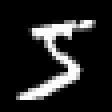
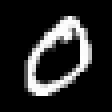
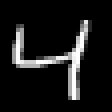
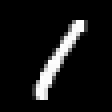
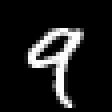

In [9]:
images[1:5]

In [10]:
labels[1:5]' # transposed to match the above

1×5 LinearAlgebra.Adjoint{Int64,Array{Int64,1}}:
 5  0  4  1  9

So the $i$th entry of the array is the data for the $i$th image.

In [11]:
typeof(images[1])

Array{Gray{Normed{UInt8,8}},2}

As with the fruit images from the start of the course, the image is an array of color blocks, except that now each pixel just has a grey scale.

To see the actual numeric content of the image, we can do, for example

In [12]:
Float64.(images[1])

28×28 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0       0.0       …  0.0       0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0       0.0          0.0       0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0       0.0          0.0       0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0       0.0          0.0       0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0       0.0          0.0       0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0       0.0       …  0.498039  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0       0.0          0.25098   0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0       0.0          0.0       0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0       0.0          0.0       0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0       0.0          0.0       0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0       0.0       …  0.0       0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0       0.0          0.0       0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0       0.0          0.0       0.0  0.0  0.0  0.0
 ⋮                         

### Setting up a neural network

In the previous notebooks, we arranged the input data for Flux as a `Vector` of `Vector`s.
Now we will use an alternative arrangement, as a matrix, since that allows `Flux` to use matrix operations, which are more efficient.

The column $i$ of the matrix is a vector consisting of the $i$th data point $\mathbf{x}^{(i)}$.  Similarly, the desired outputs are given as a matrix, with the $i$th column being the desired output $\mathbf{y}^{(i)}$.

In [13]:
n_inputs = unique(length.(images))[]

784

In [14]:
n_outputs = length(unique(labels))

10

#### Creating the features

We want to create a vector of feature vectors, each with the floating point values of the 784 pixels.

An image is a matrix of colours, but now we need a vector of floating point numbers instead. To do so, we just arrange all of the elements of the matrix in a certain way into a single list; fortunately, Julia already provides the function `vec` to do so!

Let's use a subset of $N=5,000$ of the total $60,000$ images available in order to hold out test images that our model hasn't been trained on.

In [15]:
preprocess(img) = vec(Float64.(img))

preprocess (generic function with 1 method)

In [16]:
xs = preprocess.(images[1:5000]);

#### Creating the labels

We can just use `Flux.onehot` to create them:

In [17]:
ys = [Flux.onehot(label, 0:9) for label in labels[1:5000]]

5000-element Array{Flux.OneHotVector,1}:
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
 ⋮
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
 [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

#### Create the batched matrices for efficiency

Let's also create a function so we can easily create independent batches from arbitrary segments of the original dataset.

In [18]:
function create_batch(r)
    xs = [preprocess(img) for img in images[r]]
    ys = [Flux.onehot(label, 0:9) for label in labels[r]]
    return (Flux.batch(xs), Flux.batch(ys))
end

create_batch (generic function with 1 method)

We'll train our model on the first 5000 images.

In [54]:
trainbatch = create_batch(1:10000)

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Bool[0 1 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 1 0])

In [55]:
testbatch = create_batch(10001:20000);

## Setting up the neural network

Now we must set up a neural network. Since the data is complicated, we may expect to need several layers.
But we can start with a single layer.

- The network will take as inputs the vectors $\mathbf{x}^{(i)}$, so the input layer has $n$ nodes.

- The output will be a one-hot vector encoding the digit from 1 to 9 or 0 that is desired. There are 10 possible categories, so we need an output layer of size 10.

It is then our task as neural network designers to insert layers between these input and output layers, whose weights will be tuned during the learning process. *This is an art, not a science*! But major advances have come from finding a good structure for the network.

In [56]:
model = Chain(Dense(n_inputs, n_outputs, identity), softmax)

Chain(Dense(784, 10), softmax)

In [57]:
L(x,y) = Flux.crossentropy(model(x), y)

L (generic function with 1 method)

In [58]:
opt = Descent()

Descent(0.1)

## Training

In [59]:
@time Flux.train!(L, params(model), [trainbatch], opt)
@time Flux.train!(L, params(model), [trainbatch], opt)

  0.086626 seconds (10.31 k allocations: 66.679 MiB)
  0.060217 seconds (419 allocations: 66.212 MiB)


We can see what the total current loss is (after training just a handful to times above):

In [60]:
L(trainbatch...)

2.1825838f0 (tracked)

In [61]:
@time Flux.train!(L, params(model), [trainbatch], opt)

  0.073117 seconds (419 allocations: 66.212 MiB)


In [62]:
L(trainbatch...)

2.0827324f0 (tracked)

### Using callbacks

The `train!` function can take an optional keyword argument, `cb` (short for "**c**all**b**ack"). A callback function is a function that you provide as an argument to a function `f`, which "calls back" your function every so often.

This provides the possibility to provide a function that is called at each step or every so often during the training process.
A common use case is to provide a visual trace of the training process by printing out the current value of the `loss` function:

In [63]:
callback() = @show(L(trainbatch...))

Flux.train!(L, params(model), Iterators.repeated(trainbatch, 3), opt; cb = callback)

L(trainbatch...) = 1.9922386f0 (tracked)
L(trainbatch...) = 1.9091614f0 (tracked)
L(trainbatch...) = 1.8324964f0 (tracked)


However, it is expensive to calculate the complete `loss` function and it is not necessary to output it every step. So `Flux` also provides a function `throttle`, that provides a mechanism to call a given function at most once every certain number of seconds:

In [64]:
Flux.train!(L, params(model), Iterators.repeated(trainbatch, 40), opt; cb = Flux.throttle(callback, 1))

L(trainbatch...) = 1.7616191f0 (tracked)
L(trainbatch...) = 1.0796915f0 (tracked)
L(trainbatch...) = 0.8493761f0 (tracked)


Of course, that's just measuring the loss over the same data it's training on. It'd be more representative to test against novel data. In fact, let's track the performance of both as we continue training our model. In order to do so, we need to create a batch of test data.

In [65]:
using Printf
function show_loss()
    train_loss = L(trainbatch...).data
    test_loss  = L(testbatch...).data
    @printf("train loss = %.3f, test loss = %.3f\n", train_loss, test_loss)
end

show_loss (generic function with 1 method)

In [66]:
Flux.train!(L, params(model), Iterators.repeated(trainbatch, 100), opt;
            cb = Flux.throttle(show_loss, 1))

train loss = 0.807, test loss = 0.847
train loss = 0.692, test loss = 0.733
train loss = 0.626, test loss = 0.667
train loss = 0.580, test loss = 0.622
train loss = 0.546, test loss = 0.589
train loss = 0.520, test loss = 0.563


## Testing phase

We now have trained a model, i.e. we have found the parameters `W` and `b` for the network layer(s). In order to **test** if the learning procedure was really successful, we check how well the resulting trained network performs when we test it with images that the network has not yet seen!

Often, a dataset is split up into "training data" and "test (or validation) data" for this purpose, and indeed the MNIST data set has a separate pool of training data. We can instead use the images that we have not included in our reduced training process.

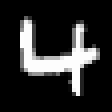

4

Tracked 10-element Array{Float32,1}:
 0.0022264877f0
 7.498947f-5
 0.012713092f0
 0.00062907155f0
 0.96550006f0
 8.5093896f-5
 0.007303311f0
 0.0014931796f0
 0.0018345749f0
 0.008140193f0

In [73]:
i = 11009
display(images[i])
display(labels[i])
model(preprocess(images[i]))

## Evaluation

What percent of images are we correctly classifying if we take the highest element to be the chosen answer?

In [74]:
prediction(i) = findmax(model(preprocess(images[i])))[2]-1 # returns (max_value, index)

prediction (generic function with 1 method)

In [75]:
sum(prediction(i) == labels[i] for i in 1:5000)/5000

0.8804

In [76]:
sum(prediction(i) == labels[i] for i in 5001:10000)/5000

0.8734

## Improving the prediction

So far we have used a single layer. In order to improve the prediction, we probably need to use more layers. Try adding more layers yourself and see how the performance changes.

In [77]:
n_hidden = 20
model = Chain(Dense(n_inputs, n_hidden, relu),
        Dense(n_hidden, n_hidden, relu),
        #Dense(n_hidden, n_hidden, relu),
              Dense(n_hidden, n_outputs, identity), softmax)
L(x,y) = Flux.crossentropy(model(x), y)
opt = ADAM()

ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}())

In [80]:
train_loss = Float64[]
test_loss = Float64[]
Flux.train!(L, params(model), Iterators.repeated(trainbatch, 500), opt;
            cb = Flux.throttle(show_loss, 1))

train loss = 0.003, test loss = 0.517
train loss = 0.003, test loss = 0.520
train loss = 0.003, test loss = 0.523
train loss = 0.003, test loss = 0.525
train loss = 0.003, test loss = 0.528
train loss = 0.003, test loss = 0.531
train loss = 0.003, test loss = 0.534
train loss = 0.003, test loss = 0.536
train loss = 0.002, test loss = 0.539
train loss = 0.002, test loss = 0.542
train loss = 0.002, test loss = 0.544
train loss = 0.002, test loss = 0.547
train loss = 0.002, test loss = 0.549
train loss = 0.002, test loss = 0.552
train loss = 0.002, test loss = 0.554
train loss = 0.002, test loss = 0.557
train loss = 0.002, test loss = 0.559
train loss = 0.002, test loss = 0.562
train loss = 0.002, test loss = 0.564
train loss = 0.002, test loss = 0.567
train loss = 0.002, test loss = 0.569
train loss = 0.002, test loss = 0.572
train loss = 0.002, test loss = 0.574
train loss = 0.002, test loss = 0.576
train loss = 0.002, test loss = 0.578
train loss = 0.001, test loss = 0.580
train loss =

In [50]:
train_loss = Float64[]
test_loss = Float64[]
Flux.train!(L, params(model), Iterators.repeated(trainbatch, 500), opt;
            cb = Flux.throttle(show_loss, 1))

train loss = 2.410, test loss = 2.382
train loss = 1.446, test loss = 1.420
train loss = 0.829, test loss = 0.844
train loss = 0.545, test loss = 0.589
train loss = 0.414, test loss = 0.478
train loss = 0.337, test loss = 0.417
train loss = 0.287, test loss = 0.381
train loss = 0.251, test loss = 0.359
train loss = 0.224, test loss = 0.345
train loss = 0.201, test loss = 0.336
train loss = 0.183, test loss = 0.330
train loss = 0.167, test loss = 0.327
train loss = 0.153, test loss = 0.326
train loss = 0.141, test loss = 0.326
train loss = 0.130, test loss = 0.328
train loss = 0.120, test loss = 0.330
train loss = 0.111, test loss = 0.333


In [48]:
train_loss = Float64[]
test_loss = Float64[]
Flux.train!(L, params(model), Iterators.repeated(trainbatch, 500), opt;
            cb = Flux.throttle(show_loss, 1))

train loss = 2.290, test loss = 2.290
train loss = 1.553, test loss = 1.562
train loss = 0.758, test loss = 0.800
train loss = 0.445, test loss = 0.526
train loss = 0.324, test loss = 0.432
train loss = 0.254, test loss = 0.388
train loss = 0.202, test loss = 0.360
train loss = 0.164, test loss = 0.344
train loss = 0.133, test loss = 0.335
train loss = 0.106, test loss = 0.332
train loss = 0.086, test loss = 0.335
train loss = 0.069, test loss = 0.343
train loss = 0.055, test loss = 0.354
train loss = 0.043, test loss = 0.368
train loss = 0.033, test loss = 0.382
train loss = 0.026, test loss = 0.396
train loss = 0.020, test loss = 0.411
train loss = 0.016, test loss = 0.425


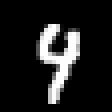

4

In [38]:
display(images[7010])
labels[7010]

In [39]:
model(preprocess(images[7010]))

Tracked 10-element Array{Float32,1}:
 8.117247f-5
 3.4368663f-6
 2.2509652f-5
 0.0084966095f0
 0.09988375f0
 0.020022659f0
 2.5050887f-5
 0.0046520564f0
 0.09729713f0
 0.7695156f0

## What about image structure?

As a final note, notice that our model doesn't take into account any aspect of the image's connected-ness.

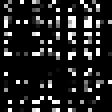

In [40]:
using Random
p = randperm(28)
images[1][p,p]

In [41]:
show(preprocess(images[1]))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.21568627450980393, 0.5333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6745098039215687, 0.9921568627450981, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

In [42]:
?Conv

search: Conv conv conv! convert ConvDims convexhull ConvTranspose ∇conv_data



```
Conv(size, in=>out)
Conv(size, in=>out, relu)
```

Standard convolutional layer. `size` should be a tuple like `(2, 2)`. `in` and `out` specify the number of input and output channels respectively.

Example: Applying Conv layer to a 1-channel input using a 2x2 window size,          giving us a 16-channel output. Output is activated with ReLU.

```
size = (2,2)
in = 1
out = 16 
Conv((2, 2), 1=>16, relu)
```

Data should be stored in WHCN order (width, height, # channels, # batches).  In other words, a 100×100 RGB image would be a `100×100×3×1` array,  and a batch of 50 would be a `100×100×3×50` array.

Takes the keyword arguments `pad`, `stride` and `dilation`.
